In [2]:
from datasets import load_dataset_builder
from datasets import load_dataset
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt

from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

from transformers import AutoTokenizer, GPT2Tokenizer, GPT2LMHeadModel 

import numpy as np
import time

from collections import OrderedDict

from torch_geometric.nn import GCNConv, SimpleConv
from tqdm.auto import tqdm

from torch_geometric.data import Batch

from sklearn.manifold import TSNE

## Helper function

In [3]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    

class ModuleHook:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.module = None
        self.features = []

    def hook_fn(self, module, input, output):
        self.module = module
        self.features.append(output.detach())

    def close(self):
        self.hook.remove()
        
        
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

## Load CoNLL POS Dataset

Tokenize raw text into a sequence of tokens and align the word-level labels with token-level labels

In [4]:
task = "pos" 
datasets = load_dataset("conll2003")
label_list = datasets["train"].features[f"{task}_tags"].feature.names

model_checkpoint = "gpt2"
batch_size = 16
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)
label_all_tokens = True
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

model = GPT2LMHeadModel.from_pretrained("gpt2").to("cuda")

Reusing dataset conll2003 (/n/home04/yidachen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /n/home04/yidachen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-560a51cc1d4af62a.arrow


  0%|          | 0/4 [00:00<?, ?ba/s]

Loading cached processed dataset at /n/home04/yidachen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-ce1b5c2cfa3b5844.arrow


## Graph Neural Network

In [7]:
from gcn_probe import GCNProbe, GCNNonlinearProbe, MLPProbe

## Create Train & Test Split for Probing Evaluation

In [8]:
np.random.seed(123)

split = "test"
num_samples = len(datasets["test"])
# num_samples = 3000
train_portion = 0.8

sampled_indices = np.random.choice(np.arange(len(tokenized_datasets[split])),
                                   num_samples, 
                                   replace=False)


sampled_train = np.random.choice(np.arange(len(sampled_indices)), 
                                 int(num_samples * train_portion), 
                                 replace=False)


sampled_test = np.setdiff1d(np.arange(len(sampled_indices)), sampled_train)


train_mask = np.array([True] * num_samples)
train_mask[sampled_test] = False


test_mask = np.array([True] * num_samples)
test_mask[sampled_train] = False

## Unweighted Directed Graph

In [9]:
model = GPT2LMHeadModel.from_pretrained("gpt2").to("cuda")
        
threshold = 0.2
layer = 4   
    
all_graphs = {}
for layer in range(12):
    all_graphs[layer] = {}
    for head in range(12):
        all_graphs[layer][head] = []
    
# graphs = []


for i in tqdm(sampled_indices):
    features = OrderedDict()
    for name, module in model.named_modules():
        if "c_attn" in name:
            features[name] = ModuleHook(module)


    with torch.no_grad():
        output = model(input_ids = torch.Tensor(tokenized_datasets[split]["input_ids"][i]).type(torch.long).to("cuda"),
                       attention_mask = torch.Tensor(tokenized_datasets[split]["attention_mask"][i]).to("cuda"),
                       output_attentions = True,
                       output_hidden_states = True)


    for feature in features.values():
        feature.close()

    y = tokenized_datasets[split]["labels"][i]
    for layer in range(12):
        value_features = features[f'transformer.h.{layer}.attn.c_attn'].features[0].split(768, dim=2)[-1][0].clone()
        for head in range(12):
            weighted_adj_matrix = output["attentions"][layer][0][head].detach().cpu()

            # node_features = output["hidden_states"][layer - 1][0].detach().cpu()

            node_features = value_features[:, head * 64: (head + 1) * 64]

            adj_matrix = weighted_adj_matrix > threshold

            edge_index = adj_matrix.detach().clone().cpu().nonzero().t().contiguous().type(torch.long)
            x = node_features

            data = Data(x=x, edge_index=edge_index, y=y)

            all_graphs[layer][head].append(data)

  0%|          | 0/3453 [00:00<?, ?it/s]

## Weighted Directed Graph 

### Before running the cell below

**The configuration below use attention score as edge weights and may consume large GPU memory**

If your GPU memory is smaller than 32GB, please skip this cell and run the cell "Unweighted Directed Graph" above instead.

In [20]:
model = GPT2LMHeadModel.from_pretrained("gpt2").to("cuda")
        
threshold = 0.0
layer = 4   
    
all_graphs = {}
for layer in range(12):
    all_graphs[layer] = {}
    for head in range(12):
        all_graphs[layer][head] = []
    
# graphs = []


for i in tqdm(sampled_indices):
    features = OrderedDict()
    for name, module in model.named_modules():
        if "c_attn" in name:
            features[name] = ModuleHook(module)


    with torch.no_grad():
        output = model(input_ids = torch.Tensor(tokenized_datasets[split]["input_ids"][i]).type(torch.long).to("cuda"),
                       attention_mask = torch.Tensor(tokenized_datasets[split]["attention_mask"][i]).to("cuda"),
                       output_attentions = True,
                       output_hidden_states = True)


    for feature in features.values():
        feature.close()

    y = tokenized_datasets[split]["labels"][i]
    for layer in range(12):
        value_features = features[f'transformer.h.{layer}.attn.c_attn'].features[0].split(768, dim=2)[-1][0].clone()
        for head in range(12):
            weighted_adj_matrix = output["attentions"][layer][0][head].detach().cpu()

            # node_features = output["hidden_states"][layer - 1][0].detach().cpu()

            node_features = value_features[:, head * 64: (head + 1) * 64]

            adj_matrix = weighted_adj_matrix > threshold

            edge_index = adj_matrix.detach().clone().cpu().nonzero().t().contiguous().type(torch.long)
            x = node_features
            
            edge_weights = weighted_adj_matrix[adj_matrix].detach().clone().cpu()

            data = Data(x=x, edge_index=edge_index, y=y, edge_weights=edge_weights)

            all_graphs[layer][head].append(data)

  0%|          | 0/3453 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 10.76 GiB total capacity; 2.42 GiB already allocated; 4.56 MiB free; 2.53 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Train and Test Helper functions

In [10]:
def train(model, optimizer, criterion, data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out, torch.Tensor(data.y).type(torch.long))  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss


def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred == torch.Tensor(data.y)  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(len(data.batch))  # Derive ratio of correct predictions.
    return test_acc

## Train Probe on Graph representations of Text at 144 Heads

In [15]:
train_accs = {}
test_accs = {}


for layer in tqdm(range(0, 12)):
    train_accs[layer] = {}
    test_accs[layer] = {}
    for head in range(0, 12):
        probe = GCNProbe(64, 47).to("cuda")
        optimizer = torch.optim.Adam(probe.parameters(), lr=0.01)
        criterion = torch.nn.CrossEntropyLoss()

        train_data = Batch.from_data_list([all_graphs[layer][head][i].to("cuda") for i in range(len(all_graphs[layer][head])) if train_mask[i]])
        train_data.y = torch.Tensor(np.concatenate(train_data.y).ravel()).type(torch.long).to("cuda")

        test_data = Batch.from_data_list([all_graphs[layer][head][i].to("cuda") for i in range(len(all_graphs[layer][head])) if test_mask[i]])
        test_data.y = torch.Tensor(np.concatenate(test_data.y).ravel()).type(torch.long).to("cuda")

        for epoch in range(1, 1001):
            loss = train(probe, optimizer, criterion, train_data)
            train_acc = test(probe, train_data)

        print("-" * 25 + f" layer {layer} head {head} " + "-" * 25)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
        print(f'Train Accuracy: {train_acc:.4f}')


        test_acc = test(probe, test_data)
        print(f'Test Accuracy: {test_acc:.4f}')
        
        train_accs[layer][head] = train_acc
        test_accs[layer][head] = test_acc

  0%|          | 0/12 [00:00<?, ?it/s]

------------------------- layer 0 head 0 -------------------------
Epoch: 1000, Loss: 1.0304
Train Accuracy: 0.7102
Test Accuracy: 0.6955
------------------------- layer 0 head 1 -------------------------
Epoch: 1000, Loss: 0.6289
Train Accuracy: 0.8196
Test Accuracy: 0.8146
------------------------- layer 0 head 2 -------------------------
Epoch: 1000, Loss: 0.8938
Train Accuracy: 0.7499
Test Accuracy: 0.7380
------------------------- layer 0 head 3 -------------------------
Epoch: 1000, Loss: 0.7930
Train Accuracy: 0.7801
Test Accuracy: 0.7683
------------------------- layer 0 head 4 -------------------------
Epoch: 1000, Loss: 0.9744
Train Accuracy: 0.7215
Test Accuracy: 0.7072
------------------------- layer 0 head 5 -------------------------
Epoch: 1000, Loss: 0.7196
Train Accuracy: 0.7928
Test Accuracy: 0.7842
------------------------- layer 0 head 6 -------------------------
Epoch: 1000, Loss: 1.0149
Train Accuracy: 0.7216
Test Accuracy: 0.7066
------------------------- layer 0 

In [ ]:
score_matrix = []

for layer in range(12):
    score_matrix.append([])
    for head in range(12):
        score_matrix[layer].append(test_accs[layer][head])

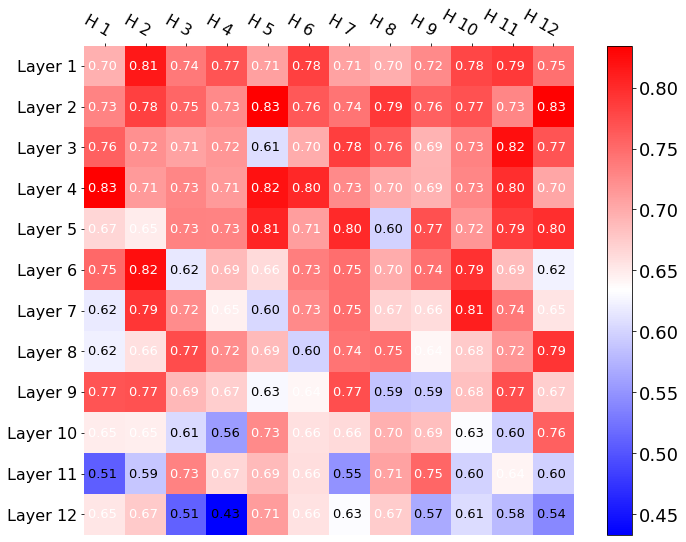

In [6]:
from visualization_utils import heatmap, annotate_heatmap
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(12, 9))

im, cbar = heatmap(np.array(score_matrix), [f"Layer {i + 1}" for i in range(12)], [f"H {i + 1}" for i in range(12)],
        cmap="bwr")

for t in cbar.ax.get_yticklabels():
     t.set_fontsize(18)

texts = annotate_heatmap(im, valfmt="{x:.2f} ", fontsize=13)

## Visualize the learnt token representation 

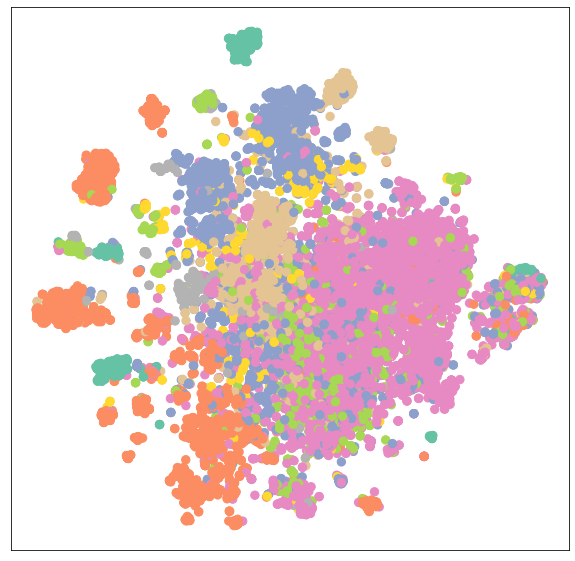

In [123]:
out = probe(test_data.x, test_data.edge_index)
visualize(out.detach().cpu(), color=test_data.y.detach().cpu())